In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import scipy as sp
import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import sklearn

import scipy.signal as signal
import scipy.fft as fft
import soundfile as sf
import librosa as lrs

import matplotlib.pyplot as plt

### Data Processing

In [3]:
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

def flatten(l):
    return [item for sublist in l for item in sublist]

def separate_strokes(onsets):
    ind = []
    for i in range(len(onsets)-1):
        if(onsets[i+1] - onsets[i] > 0.03):
            ind.append(i)
            ind.append(i+1)
    ind = np.unique(ind)
    temp = onsets[ind]
    return temp,ind

def find_doublets(onsets):
    ind = []
    for i in range(len(onsets)-1):
        if(onsets[i+1] - onsets[i] <= 0.03):
            ind.append(i)
            ind.append(i+1)
    ind = np.unique(ind)
    temp = onsets[ind]
    return temp

def remove_strokes(doublets, comp_onsets):
    ind = []
    for i in range(len(comp_onsets)):
        for j in range(len(doublets)):
            if(np.abs(comp_onsets[i] - doublets[j]) <= 0.01):
                ind.append(i)
    ind = np.unique(np.array(ind))
    return np.delete(comp_onsets, ind)

def doublet_class_gen(annot_onsets, annot_labels):
    data = []
    labels = []
    i = 0
    while i <= (len(annot_onsets)-2):
        if(np.abs(annot_onsets[i+1] - annot_onsets[i]) < 0.03):
            data.append(np.mean([annot_onsets[i+1],annot_onsets[i]]))
            labels.append(5)
            i += 2
        else:
            data.append(annot_onsets[i])
            labels.append(annot_labels[i])
            i += 1
    data.append(annot_onsets[-1])
    labels.append(annot_labels[-1])
    return np.array(data),np.array(labels)

def tran_prob(onset_labels):
    probs = np.zeros((6,6))
    for i in range(1,len(onset_labels)):
        curr = onset_labels[i]
        prev = onset_labels[i-1]
        probs[curr,prev] += 1
    return probs

In [4]:
# Define all required directories and filepaths
master_dir = r"/content/drive/My Drive/Colab Notebooks/Stroke_Classification_Data_Complete"
files = os.listdir(master_dir)
num_comp = len(files) // 6 # 1 audio file + 5 annotation files per composition
files = np.sort(np.array(files))
files = files.tolist()

In [5]:
# Extract audio and annotation data
# Convert annotation data into one-hot encoded vectors
# Compute onset times and label appropriately

num_files = 6
audio_data = []
annot_onsets = []
annot_labels = []
comp_onsets = []
comp_onset_labels = []
mag_spectra = []
# probs = np.zeros((6,6))
fs = 48000
freqs = fft.fftfreq(fs, 1/fs)

for i in range(num_comp):
    j = num_files*i
    filepath = os.path.join(master_dir, files[j])
    data, fs = sf.read(filepath)
    mono_data = data[:,0] + data[:,1]
    audio_data.append(mono_data)
    
    annot_data_tmp = []
    annot_onsets_tmp = []
    annot_labels_tmp = []
    for j in range(num_files*i + 1, num_files*(i+1)):
        filepath = os.path.join(master_dir, files[j])
        tmp = pd.read_csv(filepath, header=None)
        annot_data_tmp.append(tmp)
        
    count = 0
    for k in annot_data_tmp:
        for l in k[0]:
            annot_onsets_tmp.append(l)
            annot_labels_tmp.append(count)
        count += 1
    annot_onsets_tmp = np.array(annot_onsets_tmp)
    annot_labels_tmp = np.array(annot_labels_tmp)
    sorted_args = np.argsort(annot_onsets_tmp)
    annot_onsets_tmp = annot_onsets_tmp[sorted_args]
    annot_labels_tmp = annot_labels_tmp[sorted_args]

    annot_onsets_tmp,annot_labels_tmp = doublet_class_gen(annot_onsets_tmp,annot_labels_tmp)
    # probs = probs + tran_prob(annot_labels_tmp)
    annot_labels_tmp = one_hot(annot_labels_tmp, 6)
    annot_onsets.append(annot_onsets_tmp)
    annot_labels.append(annot_labels_tmp)
    
    onset_times = lrs.onset.onset_detect(y=mono_data, sr=fs, hop_length=120, units='time', backtrack=False)
    onset_labels = []
    for i in onset_times:
        tmp = np.argmin(np.abs(annot_onsets_tmp - i))
        onset_labels.append(annot_labels_tmp[tmp])
    comp_onsets.append(onset_times)
    comp_onset_labels.append(np.array(onset_labels))
    
    spectra_tmp = []
    mag_spectra_tmp = []
    onset_samples = np.rint(onset_times*fs).astype('int32')

    tmp1 = onset_samples[0] - 2*fs//100
    tmp2 = onset_samples[0] + (onset_samples[1]-onset_samples[0])//2
    spectra_tmp.append(fft.fft(mono_data[tmp1:tmp2], fs)[0:fs//4])
    mag_spectra_tmp.append(np.abs(spectra_tmp[0]))

    for m in range(1,len(onset_times)-1):
        tmp1 = onset_samples[m] - 2*fs//100
        tmp2 = onset_samples[m] + (onset_samples[m+1]-onset_samples[m])//2
        spectra_tmp.append(fft.fft(mono_data[tmp1:tmp2], fs)[0:fs//4])
        mag_spectra_tmp.append(np.abs(spectra_tmp[m]))

    tmp1 = onset_samples[m+1] - 2*fs//100
    tmp2 = onset_samples[m+1] + 5*fs//100
    spectra_tmp.append(fft.fft(mono_data[tmp1:tmp2], fs)[0:fs//4])
    mag_spectra_tmp.append(np.abs(spectra_tmp[m+1]))

    mag_spectra.append(mag_spectra_tmp)

mag_spectra = np.array(flatten(mag_spectra))
comp_onset_labels = np.array(flatten(comp_onset_labels))
# probs = probs/np.sum(probs,axis=0)

In [6]:
del audio_data
del annot_onsets
del comp_onsets

### Neural Net Classifier Training and Testing

In [7]:
def build_model():
    initializer = keras.initializers.HeNormal()
    inputs = keras.Input(shape =(12000,))
    x = layers.Dense(15000, 'relu', kernel_initializer=initializer)(inputs)
    x = keras.layers.Dropout(0.3)(x)
    x = layers.Dense(9000, 'relu', kernel_initializer=initializer)(x)
    x = keras.layers.Dropout(0.3)(x)
    x = layers.Dense(4500, 'relu', kernel_initializer=initializer)(x)
    x = keras.layers.Dropout(0.3)(x)
    x = layers.Dense(1500, 'relu', kernel_initializer=initializer)(x)
    x = keras.layers.Dropout(0.3)(x)
    x = layers.Dense(450, 'relu', kernel_initializer=initializer)(x)
    x = layers.Dense(100, 'relu', kernel_initializer=initializer)(x)
    outputs = layers.Dense(6, activation = 'softmax')(x)
    
    
    model = keras.Model(inputs = inputs, outputs = outputs, name = 'stroke_transcription_ann')
    model.compile(loss=keras.losses.CategoricalCrossentropy(), 
                  optimizer = keras.optimizers.Adam(learning_rate=0.0002),
                  metrics='accuracy')
    
    return model

In [8]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print(' ')
        print('.', end = '')
        
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Categorical Crossentropy")
    plt.plot(hist['epoch'], hist['loss'], label = "Training CCE")
    plt.plot(hist['epoch'], hist['val_loss'], label = "Validation CCE")
    plt.legend()
    
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(hist['epoch'], hist['accuracy'], label = "Training Accuracy")
    plt.plot(hist['epoch'], hist['val_accuracy'], label = "Validation Accuracy")
    plt.legend()

early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max', restore_best_weights=True)

In [9]:
train_data, test_data, train_labels, test_labels = sklearn.model_selection.train_test_split(
                                                   mag_spectra, comp_onset_labels,
                                                   test_size=0.15, stratify=comp_onset_labels)

grouped_spectra = [[],[],[],[],[],[]]
grouped_labels = [[],[],[],[],[],[]]
for i in range(len(train_data)):
    j = np.argmax(train_labels[i])
    grouped_spectra[j].append(train_data[i])
    grouped_labels[j].append(train_labels[i])

train_data_bal = []
train_labels_bal = []
test_data_bal = []
test_labels_bal = []
min_count = len(grouped_spectra[3])-1

for i in range(len(grouped_spectra)):
    trn_dat, tst_dat, trn_lab, tst_lab = sklearn.model_selection.train_test_split(
                                                   grouped_spectra[i], grouped_labels[i],
                                                   train_size=min_count)
    train_data_bal.append(trn_dat)
    train_labels_bal.append(trn_lab)
    test_data_bal.append(tst_dat)
    test_labels_bal.append(tst_lab)

train_data_bal = np.array(flatten(train_data_bal))
train_labels_bal = np.array(flatten(train_labels_bal))
test_data_bal = np.array(flatten(test_data_bal))
test_labels_bal = np.array(flatten(test_labels_bal))

In [10]:
total_len = len(comp_onset_labels)

weight_0 = (1 / len(grouped_labels[0])) * (total_len / 6.0)
weight_1 = (1 / len(grouped_labels[1])) * (total_len / 6.0)
weight_2 = (1 / len(grouped_labels[2])) * (total_len / 6.0)
weight_3 = (1 / len(grouped_labels[3])) * (total_len / 6.0)
weight_4 = (1 / len(grouped_labels[4])) * (total_len / 6.0)
weight_5 = (1 / len(grouped_labels[5])) * (total_len / 6.0)

class_weights = {0: weight_0, 1: weight_1, 2: weight_2, 3: weight_3, 4: weight_4, 5: weight_5}

Epoch 1/50
119/119 [==============================] - 14s 114ms/step - loss: 2.6724 - accuracy: 0.5335 - val_loss: 0.9481 - val_accuracy: 0.7188
Epoch 2/50
119/119 [==============================] - 13s 105ms/step - loss: 0.9676 - accuracy: 0.7058 - val_loss: 0.8592 - val_accuracy: 0.7517
Epoch 3/50
119/119 [==============================] - 12s 102ms/step - loss: 0.8738 - accuracy: 0.7358 - val_loss: 0.8396 - val_accuracy: 0.7562
Epoch 4/50
119/119 [==============================] - 12s 101ms/step - loss: 0.8013 - accuracy: 0.7515 - val_loss: 0.7088 - val_accuracy: 0.7981
Epoch 5/50
119/119 [==============================] - 11s 95ms/step - loss: 0.7442 - accuracy: 0.7697 - val_loss: 0.6974 - val_accuracy: 0.7966
Epoch 6/50
119/119 [==============================] - 11s 94ms/step - loss: 0.7132 - accuracy: 0.7777 - val_loss: 0.7351 - val_accuracy: 0.7779
Epoch 7/50
119/119 [==============================] - 12s 99ms/step - loss: 0.6810 - accuracy: 0.7865 - val_loss: 0.6527 - val_accur

[0.582534670829773, 0.8399401903152466]

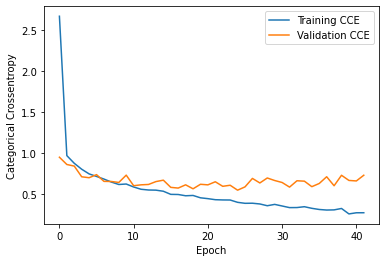

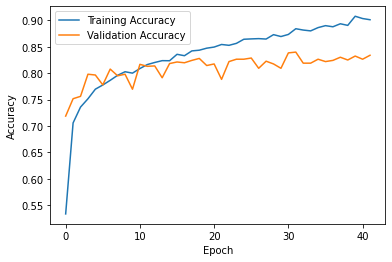

In [14]:
epochs = 50
meow = build_model()
history = meow.fit(train_data, train_labels, validation_data=(test_data,test_labels), epochs=epochs, batch_size=64, 
                   verbose=1, callbacks=[early_stop])
plot_history(history)
meow.evaluate(test_data, test_labels)

42/42 [==============================] - 0s 9ms/step


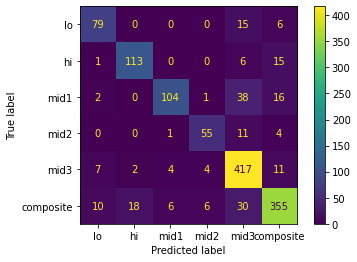

In [15]:
test_labels_int = np.argmax(test_labels, axis=1)
preds = meow.predict(test_data)
preds_int = np.argmax(preds, axis=1)
cmat = sklearn.metrics.confusion_matrix(test_labels_int, preds_int)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cmat, display_labels=['lo','hi','mid1','mid2','mid3','composite'])
disp.plot()

Epoch 1/50
119/119 [==============================] - 14s 107ms/step - loss: 3.4197 - accuracy: 0.4476 - val_loss: 1.1954 - val_accuracy: 0.6238
Epoch 2/50
119/119 [==============================] - 11s 92ms/step - loss: 1.1548 - accuracy: 0.6079 - val_loss: 1.1030 - val_accuracy: 0.5520
Epoch 3/50
119/119 [==============================] - 12s 100ms/step - loss: 1.0241 - accuracy: 0.6625 - val_loss: 1.0547 - val_accuracy: 0.6619
Epoch 4/50
119/119 [==============================] - 12s 105ms/step - loss: 1.0111 - accuracy: 0.6646 - val_loss: 0.9073 - val_accuracy: 0.7322
Epoch 5/50
119/119 [==============================] - 13s 106ms/step - loss: 0.9281 - accuracy: 0.7006 - val_loss: 0.8279 - val_accuracy: 0.7487
Epoch 6/50
119/119 [==============================] - 12s 99ms/step - loss: 0.8903 - accuracy: 0.7107 - val_loss: 1.1146 - val_accuracy: 0.5759
Epoch 7/50
119/119 [==============================] - 11s 96ms/step - loss: 0.8637 - accuracy: 0.7098 - val_loss: 0.9296 - val_accur

[0.7604628205299377, 0.8175018429756165]

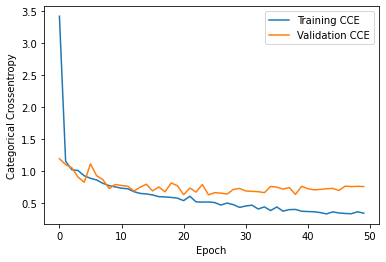

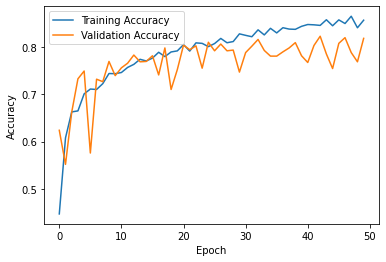

In [11]:
epochs = 50
meow = build_model()
history = meow.fit(train_data, train_labels, validation_data=(test_data,test_labels), epochs=epochs, batch_size=64, 
                   verbose=1, callbacks=[early_stop], class_weight=class_weights)
plot_history(history)
meow.evaluate(test_data, test_labels)

42/42 [==============================] - 0s 8ms/step


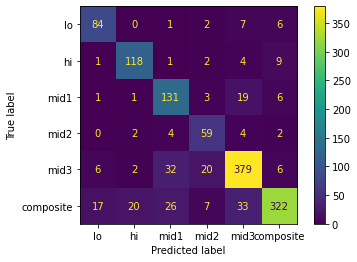

In [12]:
test_labels_int = np.argmax(test_labels, axis=1)
preds = meow.predict(test_data)
preds_int = np.argmax(preds, axis=1)
cmat = sklearn.metrics.confusion_matrix(test_labels_int, preds_int)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cmat, display_labels=['lo','hi','mid1','mid2','mid3','composite'])
disp.plot()

Epoch 1/50
38/38 [==============================] - 8s 147ms/step - loss: 5.4998 - accuracy: 0.3119 - val_loss: 1.6858 - val_accuracy: 0.3957
Epoch 2/50
38/38 [==============================] - 4s 96ms/step - loss: 1.3607 - accuracy: 0.5169 - val_loss: 1.5205 - val_accuracy: 0.3433
Epoch 3/50
38/38 [==============================] - 4s 115ms/step - loss: 1.1048 - accuracy: 0.6213 - val_loss: 1.2344 - val_accuracy: 0.5602
Epoch 4/50
38/38 [==============================] - 4s 113ms/step - loss: 1.0218 - accuracy: 0.6539 - val_loss: 1.1650 - val_accuracy: 0.5767
Epoch 5/50
38/38 [==============================] - 4s 117ms/step - loss: 0.9444 - accuracy: 0.6815 - val_loss: 0.9673 - val_accuracy: 0.6694
Epoch 6/50
38/38 [==============================] - 4s 96ms/step - loss: 0.8792 - accuracy: 0.7063 - val_loss: 1.1264 - val_accuracy: 0.6036
Epoch 7/50
38/38 [==============================] - 4s 98ms/step - loss: 0.8659 - accuracy: 0.7100 - val_loss: 0.9762 - val_accuracy: 0.6410
Epoch 8/5

[1.2765346765518188, 0.7486910820007324]

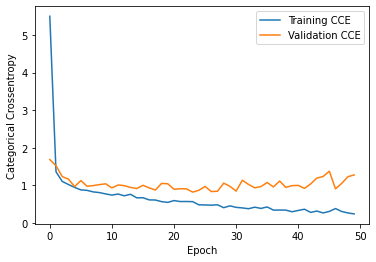

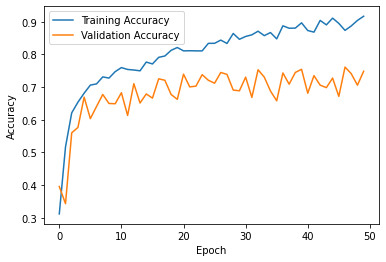

In [11]:
epochs = 50
meow = build_model()
history = meow.fit(train_data_bal, train_labels_bal, validation_data=(test_data,test_labels), epochs=epochs, batch_size=64, 
                   verbose=1, callbacks=[early_stop])
plot_history(history)
meow.evaluate(test_data, test_labels)

42/42 [==============================] - 0s 9ms/step


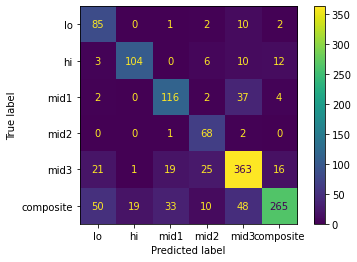

In [12]:
test_labels_int = np.argmax(test_labels, axis=1)
preds = meow.predict(test_data)
preds_int = np.argmax(preds, axis=1)
cmat = sklearn.metrics.confusion_matrix(test_labels_int, preds_int)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cmat, display_labels=['lo','hi','mid1','mid2','mid3','composite'])
disp.plot()

In [ ]:
# meow.save('/content/drive/My Drive/Colab Notebooks')

### Markov Model Incorporation

In [ ]:
# master_dir = r"/content/drive/My Drive/Colab Notebooks/Stroke_Classification_Data_Test"
# files = os.listdir(master_dir)
# num_comp = len(files) // 6 # 1 audio file + 5 annotation files per composition
# files = np.sort(np.array(files))
# files = files.tolist()

# num_files = 6
# audio_data = []
# annot_onsets = []
# annot_labels = []
# comp_onsets = []
# comp_onset_labels = []
# spectra = []
# mag_spectra = []
# fs = 48000
# freqs = fft.fftfreq(fs, 1/fs)

# i = 0
# j = num_files*i
# filepath = os.path.join(master_dir, files[j])
# data, fs = sf.read(filepath)
# mono_data = data[:,0] + data[:,1]
# audio_data.append(mono_data)

# annot_data_tmp = []
# annot_onsets_tmp = []
# annot_labels_tmp = []
# for j in range(num_files*i + 1, num_files*(i+1)):
#     filepath = os.path.join(master_dir, files[j])
#     tmp = pd.read_csv(filepath, header=None)
#     annot_data_tmp.append(tmp)
    
# count = 0
# for k in annot_data_tmp:
#     for l in k[0]:
#         annot_onsets_tmp.append(l)
#         annot_labels_tmp.append(count)
#     count += 1
# annot_onsets_tmp = np.array(annot_onsets_tmp)
# annot_labels_tmp = np.array(annot_labels_tmp)
# sorted_args = np.argsort(annot_onsets_tmp)
# annot_onsets_tmp = annot_onsets_tmp[sorted_args]
# annot_labels_tmp = annot_labels_tmp[sorted_args]

# annot_onsets_tmp,annot_labels_tmp = doublet_class_gen(annot_onsets_tmp,annot_labels_tmp)
# annot_labels_tmp = one_hot(annot_labels_tmp, 6)
# annot_onsets.append(annot_onsets_tmp)
# annot_labels.append(annot_labels_tmp)

# onset_times = lrs.onset.onset_detect(y=mono_data, sr=fs, hop_length=120, units='time', backtrack=False)
# onset_labels = []
# for i in onset_times:
#     tmp = np.argmin(np.abs(annot_onsets_tmp - i))
#     onset_labels.append(annot_labels_tmp[tmp])
# comp_onsets.append(onset_times)
# comp_onset_labels.append(np.array(onset_labels))

# spectra_tmp = []
# mag_spectra_tmp = []
# onset_samples = np.rint(onset_times*fs).astype('int32')

# tmp1 = onset_samples[0] - 2*fs//100
# tmp2 = onset_samples[0] + (onset_samples[1]-onset_samples[0])//2
# spectra_tmp.append(fft.fft(mono_data[tmp1:tmp2], fs)[0:fs//4])
# mag_spectra_tmp.append(np.abs(spectra_tmp[0]))

# for m in range(1,len(onset_times)-1):
#     tmp1 = onset_samples[m] - 2*fs//100
#     tmp2 = onset_samples[m] + (onset_samples[m+1]-onset_samples[m])//2
#     spectra_tmp.append(fft.fft(mono_data[tmp1:tmp2], fs)[0:fs//4])
#     mag_spectra_tmp.append(np.abs(spectra_tmp[m]))

# tmp1 = onset_samples[m+1] - 2*fs//100
# tmp2 = onset_samples[m+1] + fs//10
# spectra_tmp.append(fft.fft(mono_data[tmp1:tmp2], fs)[0:fs//4])
# mag_spectra_tmp.append(np.abs(spectra_tmp[m+1]))

# spectra.append(spectra_tmp)
# mag_spectra.append(mag_spectra_tmp)

# comp_onset_labels = np.array(flatten(comp_onset_labels))
# mag_spectra = np.array(flatten(mag_spectra))

In [ ]:
# meow.evaluate(mag_spectra, comp_onset_labels)

In [ ]:
# test_labels_int = np.argmax(comp_onset_labels, axis=1)
# preds = meow.predict(mag_spectra)
# preds_int = np.argmax(preds, axis=1)
# new_preds = preds.copy()
# for i in range(1,len(preds)):
#     new_preds[i] = 0.5*new_preds[i] + 0.5*probs[:,preds_int[i-1]]
#     preds_int[i] = np.argmax(new_preds[i])
# # # preds_int = np.argmax(new_preds, axis=1)

# cmat = sklearn.metrics.confusion_matrix(test_labels_int, preds_int)
# cmat

In [ ]:
# np.trace(cmat)/np.sum(cmat)

### SVM Classifier Training and Testing (Baseline)

In [ ]:
# train_labels_int = np.array([np.argmax(i) for i in train_labels])
# test_labels_int = np.array([np.argmax(i) for i in test_labels])

In [ ]:
# SVM = sklearn.svm.SVC()
# SVM.fit(train_data, train_labels_int)

In [ ]:
# SVM.score(test_data, test_labels_int)